## Predicting the winner of a UFC bout using fighter statistics

#### Gediyon Yilma
Mixed martial arts (MMA) is a sport that has exploded in popularity in recent years, and one that I follow pretty closely. The UFC is by far the largest MMA promotion in America, and like most major sports franchises the bouts are widely gambled on. I want to see if I can use historical fighter data (fighter age, strikes landed per minute, strikes absorbed per minute, and so on) as well as stats on their opponent, to predict whether that fighter will win a given bout at a higher accuracy than the bookmakers. Of course bookmakers odds are not strictly speaking predictions, they are to be interpreted as the probability that a given fighter wins/loses. Uncharitibly to the bookmakers I'm going to interpret the odds as a prediction-- the favorite is predicted to win. I will uncover the bookmakers success rate, and see if I can find a way to predict the winner that is more accurate. A more accurate way of predicting winners would be helpful to the many sports gamblers out there. Furthermore, odds are calculated based on the publics expectation of who will win (how people are actually betting). Many more people bet during title fights, as there is more media/publicity surrounding the event and hence more awareness. Many people who do not usually bet may bet on a title fight, and skew the odds, perhaps making them less reliable (for example by betting for the fighter who's personality they like). I want to see if the odds for title fights are less reliable as a result of this.

# The data
I will be using two datasets for this analysis. The first is UFC odds data from March 21, 2010 up to March 14, 2020, obtained from Kaggle. The columns are shown below. R_fighter stands for "red fighter," i.e the fighter in the red corner, and B_fighter 
stands for "blue fighter."

In [44]:
import pandas as pd
odds_data = pd.read_csv("data.csv", sep=',')
odds_data.head()

,R_fighter,B_fighter,R_odds,B_odds,date,location,country,Winner,title_bout,weight_class,gender
0,Kevin Lee,Charles Oliveira,-145.0,135.0,3/14/2020,"Brasilia, Distrito Federal, Brazil",Brazil,Blue,False,Lightweight,MALE
1,Demian Maia,Gilbert Burns,160.0,-170.0,3/14/2020,"Brasilia, Distrito Federal, Brazil",Brazil,Blue,False,Welterweight,MALE
2,Renato Moicano,Damir Hadzovic,-345.0,315.0,3/14/2020,"Brasilia, Distrito Federal, Brazil",Brazil,Red,False,Lightweight,MALE
3,Johnny Walker,Nikita Krylov,-137.0,127.0,3/14/2020,"Brasilia, Distrito Federal, Brazil",Brazil,Blue,False,Light Heavyweight,MALE
4,Francisco Trinaldo,John Makdessi,-160.0,150.0,3/14/2020,"Brasilia, Distrito Federal, Brazil",Brazil,Red,False,Lightweight,MALE


The second dataset is UFC fighter data from 1993 to 2021, also obtained from Kaggle. The columns are shown below.

In [45]:
fighter_data = pd.read_csv("raw_fighter_details.csv", sep=',')
fighter_data

,fighter_name,Height,Weight,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Tom Aaron,NaN,155 lbs.,NaN,NaN,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,Papy Abedi,"5' 11""",185 lbs.,NaN,Southpaw,"Jun 30, 1978",2.80,55%,3.15,48%,3.47,57%,50%,1.3
2,Shamil Abdurakhimov,"6' 3""",235 lbs.,"76""",Orthodox,"Sep 02, 1981",2.45,44%,2.45,58%,1.23,24%,47%,0.2
3,Danny Abbadi,"5' 11""",155 lbs.,NaN,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0
4,Hiroyuki Abe,"5' 6""",145 lbs.,NaN,Orthodox,NaN,1.71,36%,3.11,63%,0.00,0%,33%,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591,Zhang Tiequan,"5' 8""",155 lbs.,"69""",Orthodox,"Jul 25, 1978",1.23,36%,2.14,51%,1.95,58%,75%,3.4
3592,Alex Zuniga,NaN,145 lbs.,NaN,NaN,NaN,0.00,0%,0.00,0%,0.00,0%,0%,0.0
3593,George Zuniga,"5' 9""",185 lbs.,NaN,NaN,NaN,7.64,38%,5.45,37%,0.00,0%,100%,0.0
3594,Allan Zuniga,"5' 7""",155 lbs.,"70""",Orthodox,"Apr 04, 1992",3.93,52%,1.80,61%,0.00,0%,57%,1.0


## Cleaning the odds dataset
The first thing I want to do is clean the odds dataset for my purposes. I only care who was predicted to win by the odds, and who actually won. I'll keep the fighter names for now as I will need them to combine the odds dataset with the fighter dataset later on. For now I'll drop all columns except R_fighter, B_fighter, R_odds, B_odds, title_bout, and Winner. 

In [46]:
odds_data = odds_data.drop(['date','location','country','weight_class','gender'],axis=1)
odds_data

,R_fighter,B_fighter,R_odds,B_odds,Winner,title_bout
0,Kevin Lee,Charles Oliveira,-145.0,135.0,Blue,False
1,Demian Maia,Gilbert Burns,160.0,-170.0,Blue,False
2,Renato Moicano,Damir Hadzovic,-345.0,315.0,Red,False
3,Johnny Walker,Nikita Krylov,-137.0,127.0,Blue,False
4,Francisco Trinaldo,John Makdessi,-160.0,150.0,Red,False
...,...,...,...,...,...,...
5523,NaN,NaN,NaN,NaN,NaN,NaN
5524,NaN,NaN,NaN,NaN,NaN,NaN
5525,NaN,NaN,NaN,NaN,NaN,NaN
5526,NaN,NaN,NaN,NaN,NaN,NaN


Then I will add two new columns, "R_won" which will equal 1 if the red fighter won and 0 otherwise, and "R_pred" which will equal 1 if the red fighter was predicted to win, and 0 otherwise. I will also convert title_bout to 0 and 1 (for false and true), and add a column to indicate if the odds were right, "pred_correct", 1 if its correct and 0 otherwise.

In [47]:
import numpy as np
# first I want to drop all rows containing Nan
odds_data = odds_data.dropna()
odds_data = odds_data.reset_index(drop=True)
# Second I will convert the title bout information to 0s and 1s, and apply that to the dataframe
def make_bool(x):
    return 1*x
odds_data['title_bout'] = odds_data['title_bout'].apply(make_bool)



# Then I will make some lists for my new columns.
r_pred = list()
r_won = list()
pred_correct = list()
# And then iterate through the dataframe populating the two lists
for x in odds_data.iterrows():
#     For each row, I obtain the odds for red and blue, and the winner
    r_odds = x[1].values[2]
    b_odds = x[1].values[3]
    winner = x[1].values[4]
    pred = 0
    win = 0
#     append a 1 if red was the favorite, 0 otherwise
    if r_odds < b_odds:
        pred = 1
        r_pred.append(pred)
    else:
        r_pred.append(pred)
#         append a 1 if red was the winner, 0 otherwise
    if winner=="Red":
        win = 1
        r_won.append(win)
    else:
        r_won.append(win)
    if pred==win:
        pred_correct.append(1)
    else:
        pred_correct.append(0)
        
   
# add my now populated lists as columns to the dataframe.
odds_data['R_pred'] = r_pred
odds_data['R_won'] = r_won
odds_data['pred_correct'] = pred_correct

# Lets take a look at the some of the rows
odds_data


,R_fighter,B_fighter,R_odds,B_odds,Winner,title_bout,R_pred,R_won,pred_correct
0,Kevin Lee,Charles Oliveira,-145.0,135.0,Blue,0,1,0,0
1,Demian Maia,Gilbert Burns,160.0,-170.0,Blue,0,0,0,1
2,Renato Moicano,Damir Hadzovic,-345.0,315.0,Red,0,1,1,1
3,Johnny Walker,Nikita Krylov,-137.0,127.0,Blue,0,1,0,0
4,Francisco Trinaldo,John Makdessi,-160.0,150.0,Red,0,1,1,1
...,...,...,...,...,...,...,...,...,...
4235,Duane Ludwig,Darren Elkins,-155.0,135.0,Blue,0,1,0,0
4236,John Howard,Daniel Roberts,-210.0,175.0,Red,0,1,1,1
4237,Brendan Schaub,Chase Gormley,-260.0,220.0,Red,0,1,1,1
4238,Mike Pierce,Julio Paulino,-420.0,335.0,Red,0,1,1,1


## Exploratory analysis
Now lets do some exploratory analysis! I want to find out how good the official odds are at predicting the winner of a bout. To do this, I will simply get the normalized value counts for pred_correct

In [48]:
odds_data['pred_correct'].value_counts(normalize=True)

1    0.648349
0    0.351651
Name: pred_correct, dtype: float64

As we can see above, around 64.8% of the time, pred_correct = 1, i.e the fighter whom the odds favor wins. I now want to see if other factors can affect the accuracy of the prediction. In addition to testing my initial hunch that the odds are less reliable for title fights, I want to test if the odds are more or less reliable in cases where the odds heavily favor one fighter over the other, 'skewed odds.'

I'm going to approach this by defining 'skewed odds' as a fight in which the odds differential between the two fighters is >= 500. This tells us that one of the fighters is a heavy favorite. Then I will add a new column, 'mismatch' which is 1 if one fighter is heavily favored by this criteria, and 0 otherwise. I will then see if the odds predict better when there is a mismatch. Additionally, I will test my intial prediction that the odds are less reliable for title fights.

In [49]:
mismatch = list()
for x in odds_data.iterrows():
#     For each row, I obtain the odds for red and blue
    r_odds = x[1].values[2]
    b_odds = x[1].values[3]
    diff = abs(r_odds-b_odds)
#     append a 1 if odds differentilal > = 500, 0 otherwise
    if diff>=500:
        mismatch.append(1)
    else:
        mismatch.append(0)
odds_data['mismatch'] = mismatch
odds_data

,R_fighter,B_fighter,R_odds,B_odds,Winner,title_bout,R_pred,R_won,pred_correct,mismatch
0,Kevin Lee,Charles Oliveira,-145.0,135.0,Blue,0,1,0,0,0
1,Demian Maia,Gilbert Burns,160.0,-170.0,Blue,0,0,0,1,0
2,Renato Moicano,Damir Hadzovic,-345.0,315.0,Red,0,1,1,1,1
3,Johnny Walker,Nikita Krylov,-137.0,127.0,Blue,0,1,0,0,0
4,Francisco Trinaldo,John Makdessi,-160.0,150.0,Red,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
4235,Duane Ludwig,Darren Elkins,-155.0,135.0,Blue,0,1,0,0,0
4236,John Howard,Daniel Roberts,-210.0,175.0,Red,0,1,1,1,0
4237,Brendan Schaub,Chase Gormley,-260.0,220.0,Red,0,1,1,1,0
4238,Mike Pierce,Julio Paulino,-420.0,335.0,Red,0,1,1,1,1


Now to see how these factors affect the accuracy of the odds, starting with whether the fight is a title fight or not.

To get a visual sense of the data, I will make a stacked barchart of normalized correct predictions when the bout is a title bout, and correct predictions when it is not. 

The first bar shows the proportions of correct predictions when it is not a title bout. Orange indicates a correct prediction, and blue an incorrect one. It is hard to tell visually which bar has more correct predictions in it, but we can clearly see that in both the orange part is larger, indicating that a majority of the predictions are accurate.

<AxesSubplot:xlabel='title_bout'>

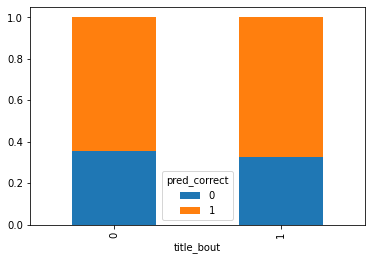

In [22]:
pd.crosstab(odds_data['title_bout'],odds_data['pred_correct'],normalize='index').plot.bar(stacked=True)

We can also look at the proportions numerically. Below, we can see that, for title bouts, the odds predict the winner correctly about 67.3% of the time, and predict incorrectly abouut 32.7% of the time. For non-title bouts the odds are reliable about 64.7% of the time and unreliable around 35.3% of the time. Both values are fairly close, indicating that whether it is a title fight has little impact on the reliability of the odds.

In [23]:
pd.crosstab(odds_data['title_bout'],odds_data['pred_correct'],normalize='index')

pred_correct,0,1
title_bout,,
0,0.352956,0.647044
1,0.327103,0.672897


We can do exactly the same analysis for mismatches. We can see visually below that the odds are about one fourth more reliable when there is a mismatch.

<AxesSubplot:xlabel='mismatch'>

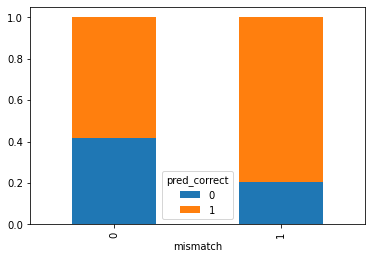

In [50]:
pd.crosstab(odds_data['mismatch'],odds_data['pred_correct'],normalize='index').plot.bar(stacked=True)

Performing a numerical analysis, we see below that for mismatches the odds are reliable approximately 79.3% of the time, and unreliable about 20.7% of the time. For non-mismatches the odds are 41.8% unreliable, 58.2% reliable. Clearly, the accuracy of the odds increases the more of a mismatch there is.

In [25]:
pd.crosstab(odds_data['mismatch'],odds_data['pred_correct'],normalize='index')

pred_correct,0,1
mismatch,,
0,0.417957,0.582043
1,0.207052,0.792948


## Prediction target
I would like to match or exceed the official odds using machine learning. So my target accuracy will be 64.8% or greater. I will then see how my prediction model fares for mismatches and title bouts.

## Cleaning the fighter stats dataset
For the fighter stat dataset I am going to keep the name column, so that I can match stats with odds data. I will drop rows containing NaN, convert stance data (southpaw, othodox, switch, open stance) into dummy variables, convert height into inches, and date of birth to just year of birth. I will drop the weight column since fights are by weight class (in any given bout two fighters will have the same weight, so it won't have any predictive value on who wins).

In [51]:
# first I will drop all NA coulumns, as well as weight
fighter_data = fighter_data.dropna().drop('Weight',axis=1)
fighter_data.head()

,fighter_name,Height,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
2,Shamil Abdurakhimov,"6' 3""","76""",Orthodox,"Sep 02, 1981",2.45,44%,2.45,58%,1.23,24%,47%,0.2
6,Daichi Abe,"5' 11""","71""",Orthodox,"Nov 27, 1991",3.80,33%,4.49,56%,0.33,50%,0%,0.0
8,Klidson Abreu,"6' 0""","74""",Orthodox,"Dec 24, 1992",2.05,40%,2.90,55%,0.64,20%,80%,0.0
11,Juan Adams,"6' 5""","80""",Orthodox,"Jan 16, 1992",7.09,55%,4.06,34%,0.91,66%,57%,0.0
12,Anthony Adams,"6' 1""","76""",Orthodox,"Jan 13, 1988",3.17,41%,5.93,44%,0.00,0%,0%,0.0


In [52]:
# Then I will define some functions to convert columns into more manageable form. I will define functions to convert
# height to inches, strip the """ symbol from reach entries, convert DOB to only year of birth, and strip the "%" symbol
# from any entries that contain it.

def feet_to_inches(string):
    string = string.split("'")
    string[1] = string[1].split("\"")[0]
    feet = string[0]
    inches = string[1]
    tot_inches = int(feet)*12 + int(inches)
    return tot_inches

def strip_quotes(string):
    string = string.split("\"")
    return int(string[0])
    
def strip_percent(string):
    string = string.split("%")
    string = int(string[0])/100
    return string

def extract_YOB(string):
    string = int(string.split(",")[1])
    return string

# Then I apply the functions to the dataset
fighter_data['Height'] = fighter_data['Height'].apply(feet_to_inches)
fighter_data['Reach'] = fighter_data['Reach'].apply(strip_quotes)
fighter_data['Str_Acc'] = fighter_data['Str_Acc'].apply(strip_percent)
fighter_data['Str_Def'] = fighter_data['Str_Def'].apply(strip_percent)
fighter_data['TD_Acc'] = fighter_data['TD_Acc'].apply(strip_percent)
fighter_data['TD_Def'] = fighter_data['TD_Def'].apply(strip_percent)
fighter_data['DOB'] = fighter_data['DOB'].apply(extract_YOB)

# And finally get dummy variables for the stance data, dropping first to avoid the dummy trap, and then drop the stance
# column
fighter_data = pd.concat((fighter_data, pd.get_dummies(fighter_data['Stance'],drop_first=True)), axis=1)
fighter_data = fighter_data.drop('Stance',axis=1)

fighter_data = fighter_data.reset_index(drop=True)
# And take a look at the first few entries
fighter_data.head()

,fighter_name,Height,Reach,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg,Orthodox,Southpaw,Switch
0,Shamil Abdurakhimov,75,76,1981,2.45,0.44,2.45,0.58,1.23,0.24,0.47,0.2,1,0,0
1,Daichi Abe,71,71,1991,3.80,0.33,4.49,0.56,0.33,0.50,0.00,0.0,1,0,0
2,Klidson Abreu,72,74,1992,2.05,0.40,2.90,0.55,0.64,0.20,0.80,0.0,1,0,0
3,Juan Adams,77,80,1992,7.09,0.55,4.06,0.34,0.91,0.66,0.57,0.0,1,0,0
4,Anthony Adams,73,76,1988,3.17,0.41,5.93,0.44,0.00,0.00,0.00,0.0,1,0,0


So far so good. All the columns in the fighter dataset are numerical (except name, which I am going to use to combine the two datasets)

## Combining the datasets

My approach for combining odds data and fighter data is as follows: For each fighter name in the fighter data set, I will search for a row in the odds dataset where the name of either the red fighter or the blue fighter matches. Then I will add cells to that row for the fighter data, i.e R_height, R_DOB, etc. Once I am done, I will remove rows where data is missing for either fighter. I will then remove the name columns, odds columns, winner column, title_bout column, pred_correct, R_pred, and mismatch columns from the combined dataset. This will leave me with a dataset where each row contains the fighter stats for the red fighter, the fighter stats for the blue fighter, and whether or not the red fighter won the bout. I can then run my classification algorithm on this dataset, and see if I can predict who wins with greater than 64.8% accuracy.

Lets get started!

In [53]:
# First of all, I want to remove rows in the odds table that do not have a matching entry in the fighter table for either
# the red or the blue fighter. 
comb_odds_data = odds_data.copy(deep=True)
for index, row in comb_odds_data.iterrows():
    r_fighter = row["R_fighter"]
    b_fighter = row["B_fighter"]
    search_red = fighter_data.loc[(fighter_data['fighter_name'] == r_fighter)]
    search_blue = fighter_data.loc[(fighter_data['fighter_name'] == b_fighter)]
    if search_red.empty and search_blue.empty:
        comb_odds_data = comb_odds_data.drop(index, inplace=False)
comb_odds_data = comb_odds_data.reset_index(drop=True)       

In [54]:
# Now lets print out some of the odds data frame to see how many entries we discarded. Recall that the original odds dataset
# had 4239 entries.

comb_odds_data

,R_fighter,B_fighter,R_odds,B_odds,Winner,title_bout,R_pred,R_won,pred_correct,mismatch
0,Kevin Lee,Charles Oliveira,-145.0,135.0,Blue,0,1,0,0,0
1,Demian Maia,Gilbert Burns,160.0,-170.0,Blue,0,0,0,1,0
2,Renato Moicano,Damir Hadzovic,-345.0,315.0,Red,0,1,1,1,1
3,Johnny Walker,Nikita Krylov,-137.0,127.0,Blue,0,1,0,0,0
4,Francisco Trinaldo,John Makdessi,-160.0,150.0,Red,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
4209,Duane Ludwig,Darren Elkins,-155.0,135.0,Blue,0,1,0,0,0
4210,John Howard,Daniel Roberts,-210.0,175.0,Red,0,1,1,1,0
4211,Brendan Schaub,Chase Gormley,-260.0,220.0,Red,0,1,1,1,0
4212,Mike Pierce,Julio Paulino,-420.0,335.0,Red,0,1,1,1,1


Great, we can see that we only lost 26 entries, which is insignificant given the size of the dataset. Now I will iterate 
through the fighter stats dataset, and append the stats for each fighter to the corresponding row in the odds dataset.

In [55]:


# As before I'll make lists to hold the soon to be added columns. I'll make a dictionary to hold the new lists.

# keys is a list of all the column names in the fighter stats dataset, except for name
keys = [x for x in fighter_data.keys() if x != "fighter_name"]

# this dictionary will hold the columns to be added to the odds dataset
stat_dict = dict()

# Then I'll iterate through the odds dataset creating my combined dataset.
for index, row in comb_odds_data.iterrows():
#     first I get the names of the red and blue fighters from the odds dataset
    r_fighter = row["R_fighter"]
    b_fighter = row["B_fighter"]
    
#     then i locate the rows in the fighter stats dataset for the red and blue fighter
    search_red = fighter_data.loc[(fighter_data['fighter_name'] == r_fighter)]
    search_blue = fighter_data.loc[(fighter_data['fighter_name'] == b_fighter)]
    
#     then i iterate through the column names of the fighter stats dataset
    for x in keys:
#         i create a new column name by concatenating "r_" to the column name for red fighter, "b_" for blue fighter
        new_key_red = "r_"+x
        new_key_blue = "b_"+x        

        #    if the newly created red key doesn't exist in the dictionary yet, I add it and make it point to an empty list
        if new_key_red not in stat_dict.keys():
            stat_dict[new_key_red] = list()
# if the cell for a specific red fighter stat exists then i add that entry to its appropriate list in the dictionary 
        if len(search_red[x]>0):
            stat_dict[new_key_red].append(search_red[x].item())
#             if that cell is missing/empty string i add NaN to the appropriate list in the dictionary
        else:
            stat_dict[new_key_red].append(np.nan)

            #      I follow the same pattern for the blue fighter stats
        if new_key_blue not in stat_dict.keys():
            stat_dict[new_key_blue] = list()
        if len(search_blue[x]>0):
            stat_dict[new_key_blue].append(search_blue[x].item())
        else:
            stat_dict[new_key_blue].append(np.nan)


In [56]:
# Now that we have our dictionary we can add the extra columns to the odds dataset

for x in stat_dict.keys():
    comb_odds_data[x] = stat_dict[x]

In [57]:
# Lets now drop columns we don't need, as well as drop NaN values.
comb_odds_data = comb_odds_data.drop(["R_odds","B_odds","Winner","R_pred"], axis=1)
comb_odds_data = comb_odds_data.dropna()
comb_odds_data = comb_odds_data.reset_index(drop=True)
comb_odds_data

,R_fighter,B_fighter,title_bout,R_won,pred_correct,mismatch,r_Height,b_Height,r_Reach,b_Reach,...,r_TD_Def,b_TD_Def,r_Sub_Avg,b_Sub_Avg,r_Orthodox,b_Orthodox,r_Southpaw,b_Southpaw,r_Switch,b_Switch
0,Kevin Lee,Charles Oliveira,0,0,0,0,69.0,70.0,77.0,74.0,...,0.75,0.57,0.8,2.8,1.0,1.0,0.0,0.0,0.0,0.0
1,Demian Maia,Gilbert Burns,0,0,1,0,73.0,70.0,72.0,71.0,...,0.61,0.50,1.0,0.7,0.0,1.0,1.0,0.0,0.0,0.0
2,Renato Moicano,Damir Hadzovic,0,1,1,1,71.0,69.0,72.0,70.0,...,0.78,0.39,0.6,0.2,1.0,1.0,0.0,0.0,0.0,0.0
3,Johnny Walker,Nikita Krylov,0,0,0,0,78.0,75.0,82.0,77.0,...,0.60,0.55,1.2,1.3,1.0,1.0,0.0,0.0,0.0,0.0
4,Francisco Trinaldo,John Makdessi,0,1,1,0,69.0,68.0,70.0,68.0,...,0.61,0.88,0.6,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622,Clay Guida,Shannon Gugerty,0,1,1,1,67.0,70.0,70.0,71.0,...,0.68,0.50,0.7,3.4,1.0,1.0,0.0,0.0,0.0,0.0
3623,Eliot Marshall,Vladimir Matyushenko,0,0,1,0,74.0,72.0,77.0,74.0,...,0.79,0.70,0.9,0.1,1.0,1.0,0.0,0.0,0.0,0.0
3624,Duane Ludwig,Darren Elkins,0,0,0,0,70.0,70.0,70.0,71.0,...,0.59,0.58,0.1,1.2,1.0,1.0,0.0,0.0,0.0,0.0
3625,John Howard,Daniel Roberts,0,1,1,0,67.0,70.0,72.0,74.0,...,0.53,0.40,0.4,2.5,1.0,0.0,0.0,1.0,0.0,0.0


Awesome. It appears we still have a good amount of data even after dropping NaN (3627 rows). As a final sanity check before dropping the fighter names, I will search TD_Def in the fighter stats dataset for the first red fighter and the last red fighter in our combined dataset, and see if those match up.

In [58]:
print(fighter_data.loc[(fighter_data['fighter_name'] == "Kevin Lee")]["TD_Def"])
print(fighter_data.loc[(fighter_data['fighter_name'] == "Eric Schafer")]["TD_Def"])

825    0.75
Name: TD_Def, dtype: float64
1351    0.5
Name: TD_Def, dtype: float64


Excellent. We can see that Kevin Lee, the first red fighter in the combined data set has r_TD_Def = 0.75 and Eric Schafer, the last red fighter in our combined dataset, has r_TD_Def of 0.5. These match the values I printed above from searching those names in the fighter stats dataset, so I am pretty confident I have constructed my combined dataset correctly. Now we can drop the fighter names from the combined dataset, and get to predicting.

In [59]:
comb_odds_data = comb_odds_data.drop(["R_fighter","B_fighter"], axis=1)
comb_odds_data

,title_bout,R_won,pred_correct,mismatch,r_Height,b_Height,r_Reach,b_Reach,r_DOB,b_DOB,...,r_TD_Def,b_TD_Def,r_Sub_Avg,b_Sub_Avg,r_Orthodox,b_Orthodox,r_Southpaw,b_Southpaw,r_Switch,b_Switch
0,0,0,0,0,69.0,70.0,77.0,74.0,1992.0,1989.0,...,0.75,0.57,0.8,2.8,1.0,1.0,0.0,0.0,0.0,0.0
1,0,0,1,0,73.0,70.0,72.0,71.0,1977.0,1986.0,...,0.61,0.50,1.0,0.7,0.0,1.0,1.0,0.0,0.0,0.0
2,0,1,1,1,71.0,69.0,72.0,70.0,1989.0,1986.0,...,0.78,0.39,0.6,0.2,1.0,1.0,0.0,0.0,0.0,0.0
3,0,0,0,0,78.0,75.0,82.0,77.0,1992.0,1992.0,...,0.60,0.55,1.2,1.3,1.0,1.0,0.0,0.0,0.0,0.0
4,0,1,1,0,69.0,68.0,70.0,68.0,1978.0,1985.0,...,0.61,0.88,0.6,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622,0,1,1,1,67.0,70.0,70.0,71.0,1981.0,1981.0,...,0.68,0.50,0.7,3.4,1.0,1.0,0.0,0.0,0.0,0.0
3623,0,0,1,0,74.0,72.0,77.0,74.0,1980.0,1971.0,...,0.79,0.70,0.9,0.1,1.0,1.0,0.0,0.0,0.0,0.0
3624,0,0,0,0,70.0,70.0,70.0,71.0,1978.0,1984.0,...,0.59,0.58,0.1,1.2,1.0,1.0,0.0,0.0,0.0,0.0
3625,0,1,1,0,67.0,70.0,72.0,74.0,1983.0,1980.0,...,0.53,0.40,0.4,2.5,1.0,0.0,0.0,1.0,0.0,0.0


## Machine Learning
My goal is to predict the dependent variable (R_won), based on the independent variables (striking accuracy, etc) for both red and blue fighters, at a higher than or equal to 64.8% accuracy, testing the accuracy on a validation set. I think if I can get this level of accuracy on a validation set that is 25% of the data, when I actually run my model on the dataset (by predicting who won for each row, like I did using odds earlier) I will have a higher than 64.8% accuracy rate, which will be an improvement on the official odds.

This is a classification problem, R_won takes on binary values (0 or 1), so I will be using random forests to do the machine learning part.

In [60]:
# Ok lets get started. First I'll separate my dependent and independent variables. For my x, I will drop title bout inform-
# ation, mismatch, pred_correct, and R_won, and keep only the fighter statistics.
y = comb_odds_data["R_won"]
x = comb_odds_data.drop(["R_won","title_bout","pred_correct","mismatch"],axis=1)

In [61]:
# Next lets create training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x,y,random_state=101,stratify=y,test_size=0.25)

In [62]:
# Lets train our random forest now, and check its accuracy. The random state hyperparameter simply makes sure that the model
# runs the same each time, so we don't get different accuracies wwhen we run it again.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

r_forest = RandomForestClassifier(random_state=10)
r_forest.fit(x_train,y_train)

RandomForestClassifier(random_state=10)

In [63]:
# Now the moment of truth! Lets see if our random forest beats the bookies
res_pred = r_forest.predict(x_valid)
accuracy_score(y_valid,res_pred)

0.6041896361631753

We obtained 60.4% accuracy on the first try, which is better than chance but worse that our prediction target of 64.8%. I will try to improve my prediction by tweaking some hyperparameters, starting with max depth of the forest.

In [64]:
# The first hyperparameter I will tweak is max depth.
max_depth = 0
accuracy = 0
for i in range(1,100):
    r_forest = RandomForestClassifier(random_state=10,max_depth=i)
    r_forest.fit(x_train,y_train)
    res_pred = r_forest.predict(x_valid)
    if accuracy_score(y_valid,res_pred) > accuracy:
        accuracy = accuracy_score(y_valid,res_pred)
        max_depth = i
print({"max_depth":max_depth,"accuracy":accuracy})

{'max_depth': 9, 'accuracy': 0.6350606394707828}


Looking at the values printed above, max depth of 9 is associated with the greatest accuracy (63.5%), for max_depths between 1 and 100. This is closer to our prediction target, but not quite there yet. I will take this 9 as my optimum max depth, and tweak n_estimators (number of trees in the forest) next. The default is 100, I will test values between 1-100.

In [41]:

max_estimators = 1
accuracy = 0.635
for i in range(1,100):
    r_forest = RandomForestClassifier(random_state=10,max_depth=9,n_estimators=i)
    r_forest.fit(x_train,y_train)
    res_pred = r_forest.predict(x_valid)
    if accuracy_score(y_valid,res_pred) > accuracy:
        accuracy = accuracy_score(y_valid,res_pred)
        max_estimators = i
print({"max_estimators":max_estimators,"accuracy":accuracy})

{'max_estimators': 83, 'accuracy': 0.6416758544652701}


The optimum number of trees appears to be 83, and the accuracy is now 64.16%, still below our target but getting there. Next I will tweak min_samples_split, the minimum number of samples needed to split a node. The default is 2, I will test between 2 and 100 once more.

In [43]:
min_samples_split = 2
accuracy = 0.6416
for i in range(2,100):
    r_forest = RandomForestClassifier(random_state=10,max_depth=9,n_estimators=83,min_samples_split=i)
    r_forest.fit(x_train,y_train)
    res_pred = r_forest.predict(x_valid)
    if accuracy_score(y_valid,res_pred) > accuracy:
        accuracy = accuracy_score(y_valid,res_pred)
        min_samples_split = i
print({"min_samples_split":min_samples_split,"accuracy":accuracy})

{'min_samples_split': 69, 'accuracy': 0.6482910694597575}


After tuning these parameters, we have achieved the prediction target but not exceeded it at 64.8% accuracy. I will accept this model with these parameters, and now see how it performs on the dataset for mismatches and for title. First, let us see how our combined dataset's accuracy looks, since we have dropped some entries from the original dataset. As before, lets see the overall accuracy of the odds.

In [100]:
comb_odds_data['pred_correct'].value_counts(normalize=True)

1    0.641026
0    0.358974
Name: pred_correct, dtype: float64

The accuracy is about the same as the original dataset. Now lets check for title bouts:

In [99]:
pd.crosstab(comb_odds_data['title_bout'],comb_odds_data['pred_correct'],normalize='index')

pred_correct,0,1
title_bout,,
0,0.360116,0.639884
1,0.338542,0.661458


For title bouts, the accuracy is still about the same.

And for mismatches:

In [98]:
pd.crosstab(comb_odds_data['mismatch'],comb_odds_data['pred_correct'],normalize='index')

pred_correct,0,1
mismatch,,
0,0.422462,0.577538
1,0.217778,0.782222


Again the values are almost the same as in the original dataset.

Now I will add a column to the dataset, ml_pred_correct, which will equal 1 if my model predicted correctly, and 0 if not. I will then compare my model's performance for title bouts and mismatches with the official odds.

In [71]:
r_forest = RandomForestClassifier(random_state=10,max_depth=9,n_estimators=83,min_samples_split=69)
r_forest.fit(x_train,y_train)
ml_pred_correct = list()
for index,row in comb_odds_data.iterrows():
    x = row.drop(["R_won","title_bout","pred_correct","mismatch"])
    winner = row["R_won"]
    pred = r_forest.predict([x])
    if winner==pred:
        ml_pred_correct.append(1)
    else:
        ml_pred_correct.append(0)
comb_odds_data["ml_pred_correct"] = ml_pred_correct
comb_odds_data.head()

,title_bout,R_won,pred_correct,mismatch,r_Height,b_Height,r_Reach,b_Reach,r_DOB,b_DOB,...,b_TD_Def,r_Sub_Avg,b_Sub_Avg,r_Orthodox,b_Orthodox,r_Southpaw,b_Southpaw,r_Switch,b_Switch,ml_pred_correct
0,0,0,0,0,69.0,70.0,77.0,74.0,1992.0,1989.0,...,0.57,0.8,2.8,1.0,1.0,0.0,0.0,0.0,0.0,1
1,0,0,1,0,73.0,70.0,72.0,71.0,1977.0,1986.0,...,0.50,1.0,0.7,0.0,1.0,1.0,0.0,0.0,0.0,0
2,0,1,1,1,71.0,69.0,72.0,70.0,1989.0,1986.0,...,0.39,0.6,0.2,1.0,1.0,0.0,0.0,0.0,0.0,1
3,0,0,0,0,78.0,75.0,82.0,77.0,1992.0,1992.0,...,0.55,1.2,1.3,1.0,1.0,0.0,0.0,0.0,0.0,1
4,0,1,1,0,69.0,68.0,70.0,68.0,1978.0,1985.0,...,0.88,0.6,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1


The next step is to check how the ML model performs overall on the whole dataset:

In [86]:
comb_odds_data['ml_pred_correct'].value_counts(normalize=True)

1    0.731459
0    0.268541
Name: ml_pred_correct, dtype: float64

This is a very good accuracy-- 73.14% of all predictions are correct. This is significantly higher than the accuracy score we obtained using training and validation sets earlier (64.8%), and the accuracy you would get following the official odds (about 64%). It seems that the ML model is outperforming the official odds so far. Now I will see what proportion of my predictions are accurate for mismatches and for title bouts.

In [87]:
pd.crosstab(comb_odds_data['title_bout'],comb_odds_data['ml_pred_correct'],normalize='index')

ml_pred_correct,0,1
title_bout,,
0,0.272780,0.727220
1,0.192708,0.807292


For title bouts, my model performs even better, at 80%, and 72% for non title bouts. Finally, lets check for mismatches. I have a hunch that the accuracy will be greatest for mismatches, let's see if that is true.

In [88]:
pd.crosstab(comb_odds_data['mismatch'],comb_odds_data['ml_pred_correct'],normalize='index')

ml_pred_correct,0,1
mismatch,,
0,0.302158,0.697842
1,0.193778,0.806222


I was wrong about that, and it makes sense now that I think about it. "mismatch" is information gleaned from the official odds, and I don't have access to those in my model, since the model is trying to make a better prediction *without* using the odds. For mismatches the ML model performs about the same as official odds (80% for my model, 79% for the odds), but still outperforms for non-mismatches.

## Conclusion
The UFC datasets I used in this tutorial are very comprehensive, so I would expect my results to generalize well. This means that, using my model, a gambler could predict UFC fight winners better than if he used the official odds.

A savvy gambler could integrate my model into a gambling strategy. For instance, although my model has the biggest prediction advantage for title bouts (80% vs 66%) I would avoid using it for title bouts simply because there are so few title fights relative to all other fights. The next biggest advantage comes with non-mismatches (fights where the fighters odds have a less than 500 point differential). My model predicts these with 69.78% accuracy, whereas the official odds are at 57.75% accuracy. 

Here is an illustrative example of a strategy: Imagine there are ten fights on a card where the odds are fairly even, but my model predicts that the underdog will win for each of the ten, and you have ten dollars to bet on each fight (so you have a hundered dollars total), and assume each underdog is a +125 underdog. What this means is betting \\$100 will get you \\$125 if they win, so betting \\$10 will get you \\$12.50, for a total payout of \\$22.50. Lets assume the favorite is a -155 favorite. This means betting \\$10 will get you \\$6.67, for a total payout of \\$16.67. (For more explanation on how gambling odds work see the links at the end of this tutorial).

Given these assumptions, lets look at expected payout if you follow the odds (bet on the favorite) vs bet using the model's prediction.

In [107]:
# Total payout using official odds to choose all our bets (betting on the favorite). These are 10 bernoulli trials with
#  a 57.75% chance of success, which will get you $6.67, and a 42.25% chance of failure which will lose you $10. How much
# money will you expect to have in your pocket at the end, starting out with $100?

num_success = 10*0.5775
num_failure = 10*0.4225
starting_stake = 100
money_in_your_pocket = starting_stake+((-10*num_failure)+(6.67*num_success))
money_in_your_pocket

96.26925

If you follow the official odds in this scenario, you end up with \\$3.75 less than you started with-- you lost money, which isn't great, especially in this economy.

Now lets see how much you would win (or lose) using my model.

In [106]:
# Total payout using my model to choose all our bets (betting on the underdog).  These are 10 bernoulli trials with
#  a 69.78% chance of success, which will get you $12.50, and a 30.22% chance of failure which will lose you $10. How much
# money will you expect to have in your pocket at the end, starting out with $100?

num_success = 10*0.6978
num_failure = 10*0.3022
money_in_your_pocket = starting_stake+((-10*num_failure)+(12.5*num_success))
money_in_your_pocket

157.005

Will you look at that. You just won \\$57! Go buy yourself something nice.

Using this model, one good strategy would be to place bets on fights where the odds are very close, but the model predicts that the official underdog should win. I am sure there are other good strategies as well.

In summary, I think my analysis is a good application of machine learning to a real world problem. Feel free to use this code to place wagers on UFC fights, but please refer to applicable laws in your area, gamble responsibly, seek help if you feel you may have a gambling addiction, and remember that I accept no liability for any losses you may incur-- my model is accurate *in the aggregate* but anything can happen in a fight, this is up to the MMA gods.

On a final note:

**This is not an open source project**. As I worked on it I realized it might have potential as a commercial product. Therefore: default copyright laws apply, meaning that I retain all rights to my source code and no one may reproduce, distribute, or create derivative works from my work

Basically, you can use it to make bets for yourself personally, but not as a (paid or free) service to others.


### Useful links

[online betting odds/payout calculator](https://www.actionnetwork.com/betting-calculators/betting-odds-calculator)

[UFC betting odds explained](https://www.oddsshark.com/ufc/betting-odds-explained)

[Machine learning for the complete novice](https://becominghuman.ai/machine-learning-for-dummies-explained-in-2-mins-e83fbc55ac6d)

[Gambling laws by state](https://www.findlaw.com/state/gambling-and-lotteries-laws/gambling.html)
